### Estilização da Saída do Markdown

In [1]:
%%HTML
<style>
  @import url('https://fonts.googleapis.com/css2?family=JetBrains+Mono&display=swap');

  body {
    font-family: 'JetBrains Mono', -apple-system, BlinkMacSystemFont, 'Segoe WPC', 'Segoe UI', system-ui, 'Ubuntu', 'Droid Sans', sans-serif;
    line-height: 1.67;
  }
</style>


# Simulador do Sistema em Loop Fechado sob um ETM Estático

Este notebook apresenta uma análise da eficácia das condições de Co-design do Controle Acionado por Eventos (ETC), conforme proposto por Coutinho em sua pesquisa [1]. O objetivo é reproduzir os resultados obtidos por Coutinho em seu estudo.

## Importação das Bibliotecas

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct
ct.use_matlab_defaults()

## Sistema Dinâmico da Planta

### Definição do Sistema
O sistema a ser analisado é o oscilador forçado de van der Pol, cuja descrição é apresentada a seguir:

$$
\begin{aligned}
  \dot{x_1}(t) &= x_2(t) \\
  \dot{x_2}(t) &= (1-x_1^2(t))x_2(t) - x_1(t) + u(t)
  \tag{1}
\end{aligned}
$$

onde é a assumido a região de modelagem $\mathscr{D} = \{x \in \mathbb{R}^2 : |x_i| \leq r_0, i \in \mathbb{N}_{\leq2}\}$. As equações em Equação 1, podem ser reescrita como:

$$
\begin{bmatrix}
  \dot{x}_1(t) \\
  \dot{x}_2(t)
\end{bmatrix}
=
\begin{bmatrix}
  0 & 1 \\
  -1 & 1 - x_1^2(t)
\end{bmatrix}
\begin{bmatrix}
  x_1(t) \\
  x_2(t)
\end{bmatrix}
+
\begin{bmatrix}
  0 \\
  1
\end{bmatrix}
u(t)
\tag{2}
$$

Ao selecionar a função de escalonamento $z_1(x) = x_1^2$, que está limitado dentro de $\mathscr{D}$ por $z^0=0$ e $z^1=r_0^2$, as matrizes $A(x)$ e $B(x)$ podem ser escritas como:

$$A(x) = \begin{bmatrix} 0 & 1 \\ -1 & 1\end{bmatrix} + z_1(x) \begin{bmatrix} 0 & 0\\ 0 & -1\end{bmatrix}, \hspace{0.2cm} \text{e} \hspace{0.2cm} B(x) = \begin{bmatrix} 0 \\ 1 \end{bmatrix} + z_1(x) \begin{bmatrix}0 \\ 0\end{bmatrix} \tag{3}$$

Então, seguindo a abordagem de não-linearidade setorial, o sistema (1) pode ser representado em $\mathscr{D}$ pelo seguinte modelo politópico quasi-LPV:

$$\dot{x}(t) = \sum_{i = 0}^1 w_i(x)(A_ix(t)+B_iu(t))$$

onde os parâmetros dependentes dos estados são:

$$
  w_0(x)=\frac{r_0^2-x_1^2(t)}{r_0^2}, \hspace{0.33cm} w_1(x)=1-w_0(x), 
  \tag{4}
$$

e as matrizes vértices são:

$$
\begin{aligned}
  A_0 = \begin{bmatrix}
    0 & 1 \\
    -1 & 1
  \end{bmatrix},
  \hspace{1cm}
  &

  B_0 = \begin{bmatrix}
    0 \\ 1
  \end{bmatrix},
  
  \\ \\

  A_1 = \begin{bmatrix}
    0 & 1 \\
    -1 & 1 - r_0^2
  \end{bmatrix},
  \hspace{1cm}
  &
  B_1 = \begin{bmatrix}
    0 \\ 1
  \end{bmatrix}
  .
  \tag{5}
\end{aligned}
$$

### Implementação do Sistema

O código a seguir apresenta a implementação do sistema oscilatório usando o oscilador forçado de van der Pol. O sistema é definido pelas seguintes variáveis e funções:

- Variáveis:
  - $r_0$: parâmetro da região de modelagem
  - $U$: entrada do sistema
  - $X0$: estados iniciais
  - $A$: matrizes de estado do sistema
  - $B$: matrizes de entrada do sistema

- Funções:
  - ```get_w(x)```: função que calcula os parâmetros dependentes de estados para a combinação linear das matrizes A e B, baseado no estado atual x do sistema
  - ```oscillator_update(t, x, u, params)```: função de atualização do sistema que calcula a derivada do estado do sistema no tempo t, com base no estado atual x, na entrada u e nos parâmetros do sistema

O sistema é modelado como um sistema de espaço de estados (State-Space System) usando a biblioteca Control (ct) do Python. A função ```ct.ss()``` é usada para definir o sistema, onde:
- ```oscillator_update``` é a função de atualização do sistema
- ```None``` determina que a saída do sistema são todos os seus estados
- O nome do sistema é 'oscillator'
- A entrada do sistema é **'u'**
- As saídas do sistema são **'x1'** e **'x2'**
- Os estados do sistema são **'x1'** e **'x2'**

Essa implementação permite simular e estudar o comportamento dinâmico do oscilador forçado de van der Pol.

In [3]:
r0 = 5
A = [np.array([[0, 1], [-1, 1]]), np.array([[0, 1], [-1, 1 - r0 ** 2]])]
B = [np.array([[0], [1]]), np.array([[0], [1]])]


def get_w(x):
  w0 = (r0 ** 2 - x[0] ** 2) / (r0 ** 2)
  w1 = 1. - w0
  return [w0, w1]


def oscillator_update(t, x, u, params):
  w = get_w(x)
  x_dot = 0
  for i in range(len(w)):
    x_dot += w[i] * (A[i] @ x + B[i] @ u)
  return x_dot


oscillator = ct.ss(
    oscillator_update, None,
    name='oscillator',
    inputs=('u'),
    outputs=('x1', 'x2'),
    states=('x1', 'x2'),
)

### Simulação do Sistema

O código abaixo realiza a simulação do sistema definido anteriormente. Ele utiliza a função `input_output_response` da biblioteca Control (ct) do Python para simular a resposta do sistema a uma entrada específica ao longo do tempo. Os parâmetros utilizados para a simulação são os seguintes:

- `sys`: o sistema a ser simulado, que foi definido anteriormente como o oscilador forçado de van der Pol.
- `T`: vetor de tempo que define o intervalo de tempo da simulação, com passo de `step`, indo de 0 a 30.
- `U`: vetor de entrada, que foi definido como `[0.1]`.
- `X0`: vetor de condições iniciais do sistema, que foi definido como `[4.2467, 1.1155]`.

A simulação retorna duas séries temporais `t` e `y`, representando o tempo e a resposta do sistema, respectivamente. Esses dados podem ser utilizados para análise do comportamento dinâmico do sistema ao longo do tempo.

In [4]:
step = 1e-2
tf = 30
timepts = np.arange(0, tf + step, step)
U = [.1]
X0 = [4.2467, 1.1155]

t, y = ct.input_output_response(
    sys=oscillator, T=timepts,
    U=U, X0=X0,
)

### Apresentação dos Resultados

O código abaixo utiliza a biblioteca Matplotlib para criar um gráfico de duas subfiguras, cada uma representando um estado do sistema dinâmico oscilatório de Van der Pol. A função `set_axs` é definida para configurar as propriedades visuais dos gráficos de forma consistente. Esta função recebe os seguintes parâmetros:

- `axs`: os eixos do gráfico onde os dados serão plotados.
- `x`: os dados do eixo x, que representam o tempo.
- `y`: os dados do eixo y, que representam os estados do sistema.
- `label`: a legenda do gráfico.
- `x_label`: o rótulo do eixo x.
- `y_label`: o rótulo do eixo y.
- `title`: o título do gráfico.

Em seguida, é criada uma figura com duas subfiguras usando `plt.subplots()`, onde `figsize=(12, 4)` define o tamanho da figura. Dois gráficos são plotados, um para cada estado do sistema, utilizando a função `set_axs` para configurar suas propriedades visuais.

- Gráfico 1: representa o estado $x_1$ do sistema ao longo do tempo.
- Gráfico 2: representa o estado $x_2$ do sistema ao longo do tempo.

Finalmente, o título geral da figura é definido como "Sistema Dinâmico Oscilatório Van der Pol" usando `fig.suptitle()`, e a função `plt.tight_layout()` garante que a disposição dos gráficos seja adequada antes de exibi-los com `plt.show()`. Esses gráficos permitem visualizar a evolução dos estados do sistema ao longo do tempo e apresentar os resultados de forma clara e organizada.

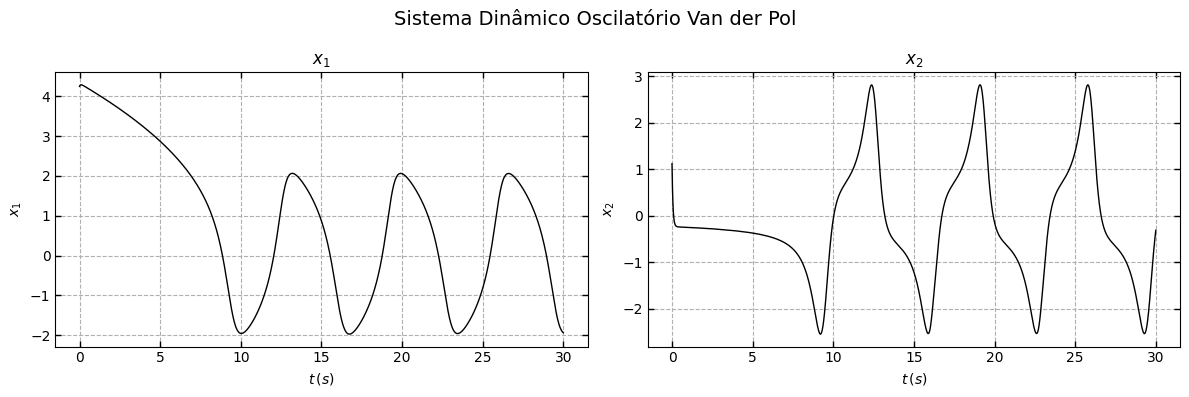

In [5]:
def set_axs(axs, x, y, label, x_label, y_label, title):
  axs.plot(x, y, linestyle='-', color='black', label=label, linewidth=1.)
  axs.set_xlabel(x_label)
  axs.set_ylabel(y_label)
  axs.set_title(title)
  # axs.legend()
  axs.grid(linestyle='--')
  axs.tick_params(axis='both', direction='in', length=4, width=1,
                  colors='black', grid_alpha=1., top=True, right=True)


fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico 1 - Estado x1
set_axs(axs[0], t, y[0], '$x_1$', '$t \, (s)$', '$x_1$', '$x_1$')

# Gráfico 2 - Estado x2
set_axs(axs[1], t, y[1], '$x_2$', '$t \, (s)$', '$x_2$', '$x_2$')

fig.suptitle('Sistema Dinâmico Oscilatório Van der Pol', fontsize=14)

plt.tight_layout()
plt.show()

## ETM Estático

In [6]:
K = [np.array([[-0.559, -3.5]]), np.array([[-6.05, -3.01]])]
Ξ = np.array([[1.36, 1.34], [1.34, 6.39]])
Ψ = np.array([[0.951, 0.333], [0.333, 1.81]])
P = np.array([[2.08e+00, 4.10e-01], [4.10e-01, 1.83e+00]])

event_times = []


def get_gama(current_states, last_states_sent):
  w_x = get_w(current_states)
  w_ex = get_w(last_states_sent)
  error = last_states_sent - current_states

  K_x, K_ex, B_x = 0, 0, 0
  for i in range(len(w_x)):
    K_x += w_x[i] * K[i]
    K_ex += w_ex[i] * K[i]
    B_x += w_x[i] * B[i]

  ζ = 2 * current_states.T @ P @ B_x @ (K_ex - K_x) @ last_states_sent
  return current_states.T @ Ψ @ current_states - error.T @ Ξ @ error - ζ


def etm_output(t, x, u, params):
  global zero, event_times

  if t != etm_output.previous_time:
    etm_output.previous_time = t
    if etm_output.first_simulation and t == 0.:
      etm_output.first_simulation = False

  last_states_sent = u[0:2]
  current_states = u[2:4]

  Γ = get_gama(current_states, last_states_sent)
  trigger = Γ < 0

  if etm_output.first_simulation and trigger:
    event_times.append(t)

  state_to_sent = (current_states if trigger or t == 0. else last_states_sent)
  return [trigger, state_to_sent[0], state_to_sent[1]]


etm_output.previous_time = 0
etm_output.first_simulation = True

ETM = ct.NonlinearIOSystem(
    None, etm_output,
    name='etm',
    inputs=('x1_hat', 'x2_hat', 'x1', 'x2'),
    outputs=('Γ', 'x1', 'x2'),
)


def zoh_output(t, x, u, params):
  if t != zoh_output.previous_time:
    zoh_output.last_states_sent = zoh_output.previous
    zoh_output.previous_time = t
  zoh_output.previous = u
  return zoh_output.last_states_sent


zoh_output.previous_time = 0
zoh_output.previous = []
zoh_output.last_states_sent = [0, 0]

ZOH = ct.ss(
    None, zoh_output,
    name='zoh',
    inputs=('x1', 'x2'),
    outputs=('x1_hat', 'x2_hat'),
)


def control_output(t, x, u, params):
  states_received = u
  w = get_w(states_received)

  y = 0
  for i in range(len(w)):
    y += w[i] * K[i] @ states_received

  return [y]


CONTROL = ct.NonlinearIOSystem(
    None, control_output,
    name='control',
    inputs=('x1_hat', 'x2_hat'),
    outputs=('u'),
)

CLOSED_LOOP_SYSTEM = ct.interconnect(
    (oscillator, ETM, ZOH, CONTROL),
    connections=(
        # Conexão entre a saída do controlador e a planta
        ('oscillator.u', 'control.u'),

        # Conexão entre as saídas do ZOH e da planta ao ETM
        ('etm.x1_hat', 'zoh.x1_hat'),
        ('etm.x2_hat', 'zoh.x2_hat'),
        ('etm.x1', 'oscillator.x1'),
        ('etm.x2', 'oscillator.x2'),

        # Conexão da saída do ETM no ZOH
        ('zoh.x1', 'etm.x1'),
        ('zoh.x2', 'etm.x2'),

        # Conexão da saída do ZOH no controlador
        ('control.x1_hat', 'zoh.x1_hat'),
        ('control.x2_hat', 'zoh.x2_hat'),
    ),
    name='closed-loop system',
    outlist=('oscillator.x1',
             'oscillator.x2',
             'etm.Γ',
             'oscillator.u',
             ),
    output=('x1', 'x2', 'Γ', 'u')
)

print(CLOSED_LOOP_SYSTEM)
print('')

step = 1e-4
timepts = np.arange(0, 30 + step, step)
t, y = ct.input_output_response(
    sys=CLOSED_LOOP_SYSTEM, T=timepts,
    X0=[4.2467, 1.1155],
    solve_ivp_method='RK45',
    solve_ivp_kwargs={'max_step': step}
)

inter_event_times = []

for i in range(1, len(event_times)):
  inter_event_times.append(event_times[i] - event_times[i-1])

<InterconnectedSystem>: closed-loop system
Inputs (0): []
Outputs (4): ['x1', 'x2', 'Γ', 'u']
States (2): ['oscillator_x1', 'oscillator_x2']



In [ ]:
figsize = (8, 4)

# Gráfico 1: Estado do Sistema x1
plt.figure(figsize=figsize)
set_axs(plt.gca(), t, y[0], '$x_1$', '$t\,(s)$',
        '$x_1$', 'Estado do Sistema $x_1$')
plt.savefig('../assets/imgs/static-etm/state-x1.svg', format='svg')
plt.close()

# Gráfico 2: Estado do Sistema x2
plt.figure(figsize=figsize)
set_axs(plt.gca(), t, y[1], '$x_2$', '$t\,(s)$',
        '$x_2$', 'Estado do Sistema $x_2$')
plt.savefig('../assets/imgs/static-etm/state-x2.svg', format='svg')
plt.close()

# Gráfico 3: Entrada do Sistema u
plt.figure(figsize=figsize)
set_axs(plt.gca(), t[1:], y[3][1:], '$u$', '$t\,(s)$',
        '$u$', 'Entrada do Sistema $u$')
plt.savefig('../assets/imgs/static-etm/input-u.svg', format='svg')
plt.close()

# Gráfico 4: Inter-event times
plt.figure(figsize=figsize)
plt.stem(event_times[1:], inter_event_times,
         linefmt='black', markerfmt='o', basefmt=' ', bottom=0)
plt.xlabel('$t\,(s)$')
plt.ylabel('inter-event times')
plt.title('Inter-event times')
plt.grid(linestyle='--')
plt.savefig('../assets/imgs/static-etm/inter-event-times.svg', format='svg')
plt.close()

### Estados do Sistema

As figuras abaixo apresentam a evolução temporal dos estados do sistema dinâmico ao longo do tempo, representado no eixo horizontal. O estado $x_1$ e $x_2$ são plotados em função do tempo $t$, demonstrando as mudanças no sistema ao longo de um intervalo de tempo específico. Os eixos são rotulados de acordo, com o eixo horizontal representando o tempo em segundos e o eixo vertical representando os estados. Este gráfico oferece uma visualização clara e concisa da dinâmica do sistema em relação ao estado $x_1$ e $x_2$.

<p align="center" style="padding: 24px;">
    <img src="../assets/imgs/static-etm/state-x1.svg" alt="" style="width:45%; height:100%;"/>
    <img src="../assets/imgs/static-etm/state-x2.svg" alt="" style="width:45%; height:100%;"/>
</p>


### Entrada do Sistema $u$

A figura abaixo mostra a entrada $u$ aplicada ao sistema dinâmico em função do tempo. O eixo horizontal representa o tempo em segundos, enquanto o eixo vertical representa a entrada $u$. Este gráfico oferece uma compreensão visual da entrada fornecida ao sistema determinada pelo controlador e pelo ETM estático.

<p align="center" style="padding: 24px;">
    <img src="../assets/imgs/static-etm/input-u.svg" alt="" style="width:45%; height:100%;"/>
</p>

### Tempos entre Eventos

Por fim, a imagem a segui apresenta os tempos entre eventos disparados. Os tempos entre eventos são plotados em relação ao tempo no eixo horizontal e à duração dos intervalos entre eventos no eixo vertical.

<p align="center" style="padding: 24px;">
    <img src="../assets/imgs/static-etm/inter-event-times.svg" alt="" style="width:45%; height:100%;"/>
</p>
